In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import io
import torch 
import numpy as np
from collections import OrderedDict

%pylab inline
rcParams["figure.figsize"] = (16,5)
sys.path.append('/home/erogol/projects/')

import librosa
import librosa.display

from TTS.models.tacotron import Tacotron 
from TTS.layers import *
from TTS.utils.data import *
from TTS.utils.audio import AudioProcessor
from TTS.utils.generic_utils import load_config
from TTS.utils.text import text_to_sequence

import IPython
from IPython.display import Audio
from utils import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
def tts(model, text, CONFIG, use_cuda, ap, figures=True):                                                                
    waveform, alignment, spectrogram = create_speech(model, text, CONFIG, use_cuda, ap) 
    if figures:                                                                                                         
        visualize(alignment, spectrogram, CONFIG)                                                                       
    IPython.display.display(Audio(waveform, rate=CONFIG.sample_rate))  
    return alignment, spectrogram

In [3]:
ROOT_PATH = '../result/February-01-2018_08:55AM/'
MODEL_PATH = ROOT_PATH + '/checkpoint_6200.pth.tar'
CONFIG_PATH = ROOT_PATH + '/config.json'
OUT_FOLDER = ROOT_PATH + '/test/'
CONFIG = load_config(CONFIG_PATH)
use_cuda = False

In [4]:
# load the model
model = Tacotron(CONFIG.embedding_size, CONFIG.hidden_size,
        CONFIG.num_mels, CONFIG.num_freq, CONFIG.r)
ap = AudioProcessor(CONFIG.sample_rate, CONFIG.num_mels, CONFIG.min_level_db,
                    CONFIG.frame_shift_ms, CONFIG.frame_length_ms, CONFIG.preemphasis,
                    CONFIG.ref_level_db, CONFIG.num_freq, CONFIG.power, griffin_lim_iters=80)         

if use_cuda:
    model = torch.nn.DataParallel(model.cuda())
else:
    cp = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)
    
    # remove DataPatallel wrapper
    new_state_dict = OrderedDict()
    for k, v in cp['model'].items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    cp['model'] = new_state_dict

 | > Embedding dim : 149


In [5]:
model.load_state_dict(cp['model'])
# model.decoder.eval(); ##
model.encoder.eval();
model.postnet.eval();
# model.eval();

In [6]:
model.decoder.prenet.dropout.training

True

In [7]:
sentences = [
    "I try to speak my friend.",
    "I speak more than binary any more.",
    "I try ti implement a new TTS system."
]

In [8]:
# tts(model, sentences[2], CONFIG, use_cuda, ap)

In [9]:
import pandas as pd
df = pd.read_csv('/data/shared/KeithIto/LJSpeech-1.0/metadata.csv', delimiter='|')
print(df.shape)

(13099, 3)


Warning! doesn't seems to be converged


For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process


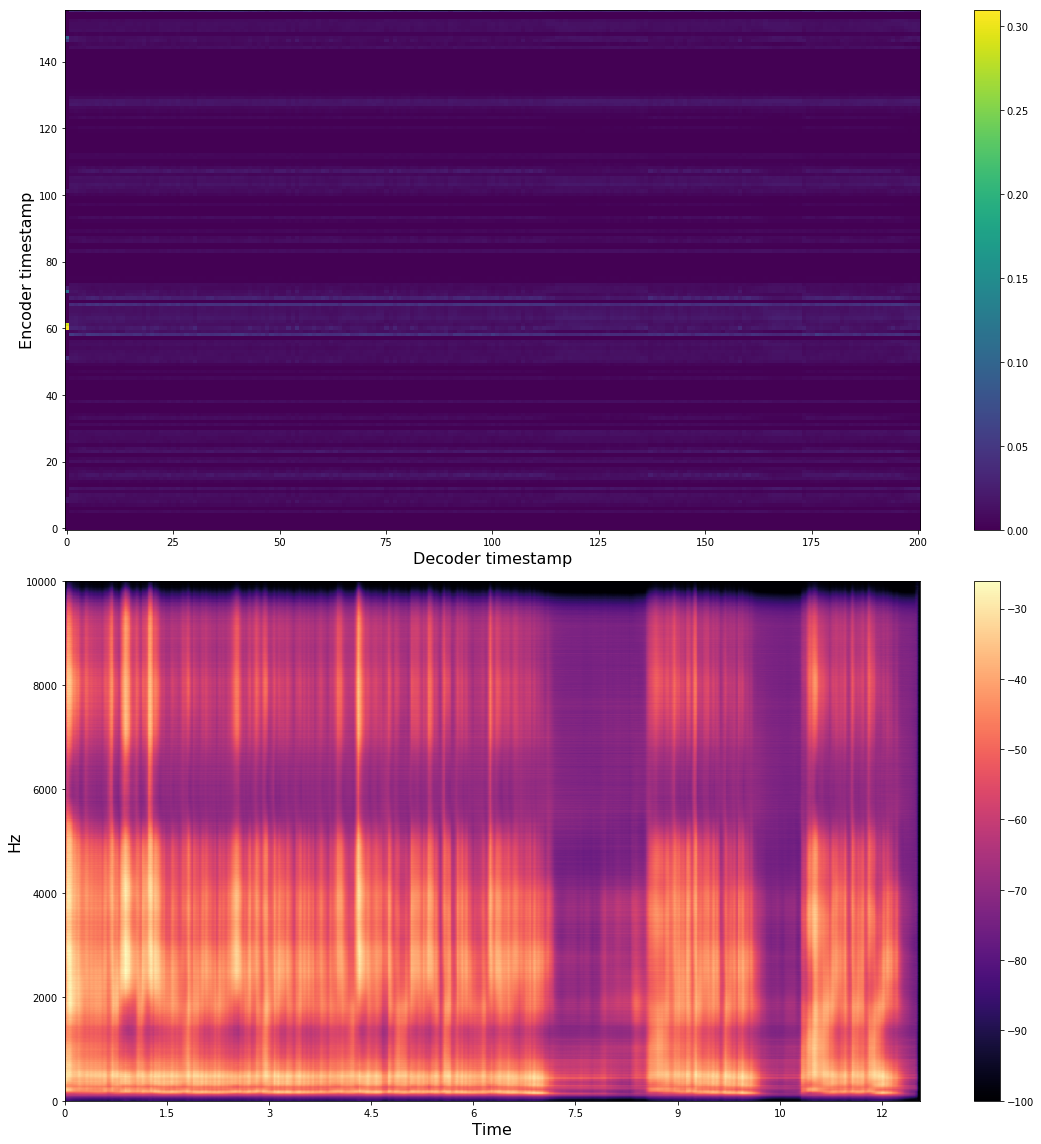

In [10]:
aling = tts(model, df.iloc[1, 1], CONFIG, use_cuda, ap)
print(df.iloc[1, 1])

In [11]:
ap._denormalize(aling[1]).min()

-100.0

In [12]:
ap._normalize(aling[1]).min()

0.0

In [13]:
# import IPython
# import glob

# # wav_files = glob.glob(OUT_FOLDER+'/**/*.wav', recursive=True)
# # assert len(wav_files) > 0
# # IPython.display.Audio(wav_files[1])
# IPython.display.display(IPython.display.Audio(wav, rate=CONFIG.sample_rate))
